In [1]:
import numpy as np
from math import pi
from matplotlib import pyplot
from scipy.linalg import block_diag

In [7]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3
m0=9.1e-31 # kg
m=m0/10

B=10 # Tesla
hwc=hbar*(elec*B/m)
lB=np.sqrt(hbar/(elec*B))
mu_sc=20*hwc #1e2*meV
D_sc=2*hwc #10*meV
nu=1
mu_n=nu*hwc #10*meV

ky_sw=np.linspace(0.,0.8,200)*3/lB
Lx=8*lB
Nx=100


def system_builder(U0,Ls):
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    Hx=np.diag(hbar**2 * kx**2/(2*m))

    def y2(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
        return c

    def y1(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
        return c

    def y0(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
        return c

    def y0s(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
        return c

    HeB2= ((elec*B)**2 * np.real(y2(k1-k2)) )/ m
    HeB2T= ((elec*B)**2 * np.real(y2(k2-k1)) )/ m
    Hef= -( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2)+U0*np.ones(k1.shape) )
    HefT=-( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1)+U0*np.ones(k1.shape) )
    Hd= D_sc*y0s(k1-k2) 

    Vn=np.zeros((2*Nx,2,len(ky_sw)), dtype=np.complex64)
    En=np.zeros((2*Nx,len(ky_sw)))
    for i_y in range(len(ky_sw)):
        ky=ky_sw[i_y]
        Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
        HeB1=-2j*hbar *ky* ( elec*B*np.imag(y1(k1-k2)))/m
        HeB1T=2j*hbar *ky* ( elec*B*np.imag(y1(k2-k1)))/m
        H1=Hx+Hy+HeB2+HeB1+Hef
        H1T=Hx+Hy+(HeB2T+HeB1T+HefT).conj()
        Hd_mat=np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)
        H_t=block_diag(H1,-H1T)+Hd_mat+np.transpose(Hd_mat).conj()
        En[:,i_y], Vs =np.linalg.eigh(H_t)
        Vn[:,0,i_y]=Vs[:,Nx-1]
        Vn[:,1,i_y]=Vs[:,Nx]

    print("Done!")
    return kx,H_t,Vn,En

In [8]:
U1=100*hwc
U2=0*hwc
Ls1=2*lB
Ls2=Ls1

kx1,H_t1,Vn1,En1= system_builder(U0=U1,Ls=Ls1)
kx2,H_t2,Vn2,En2= system_builder(U0=U2,Ls=Ls2)

Done!
Done!


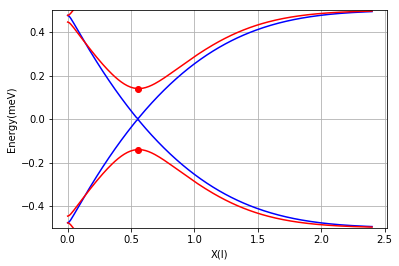

In [9]:
pyplot.figure()
pyplot.plot(ky_sw*lB,En1.T/hwc,'b')
pyplot.plot(ky_sw*lB,En2.T/hwc,'r')
pyplot.ylabel("Energy(meV)")
pyplot.xlabel("X(l)")
pyplot.ylim(-0.5,0.5)
# pyplot.ylim(-2,2)
# pyplot.xlim(-7.5,7.5)

in1=np.abs(En1[Nx-1,:]).argsort() 
ip1=np.abs(En1[Nx,:]).argsort() 
in2=np.abs(En2[Nx-1,:]).argsort() 
ip2=np.abs(En2[Nx,:]).argsort() 
# in1=np.abs(np.diff(-En1[Nx-1,:])).argsort() 
# ip1=np.abs(np.diff(En1[Nx,:])).argsort() 
# in2=np.abs(np.diff(-En2[Nx-1,:])).argsort() 
# ip2=np.abs(np.diff(En2[Nx,:])).argsort() 
# pyplot.plot(ky_sw[in1[:nu]]*lB,En1[Nx-1,in1[:nu]]/hwc,'bo')
# pyplot.plot(ky_sw[ip1[:nu]]*lB,En1[Nx,ip1[:nu]]/hwc,'bo')
pyplot.plot(ky_sw[in2[:nu]]*lB,En2[Nx-1,in2[:nu]]/hwc,'ro')
pyplot.plot(ky_sw[ip2[:nu]]*lB,En2[Nx,ip2[:nu]]/hwc,'ro')

pyplot.grid()
pyplot.show()


[[-0.05408575+1.68827450e-18j  0.10600916+3.49255938e-02j]
 [ 0.10600916-3.49255938e-02j  0.05408579-7.52005332e-19j]]
0.3294582784992316


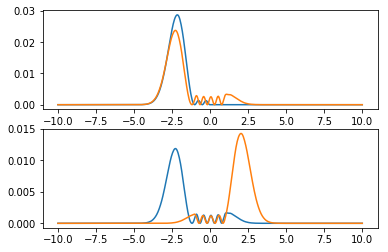

In [34]:
def wf_real_space(ev,k,x,Ls):
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    return np.dot(np.exp(1j*kt*xt),ev[:Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]), np.dot(np.exp(1j*kt*xt),ev[Nx:2*Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])

ind=0
x0=np.linspace(-1,1,500)*10*lB
wf1_p,wf1_h=wf_real_space(Vn1[:,:,ip1[ind]],kx1,x0,Ls1)
wf2_p,wf2_h=wf_real_space(Vn2[:,:,ip2[ind]],kx2,x0,Ls2)

Vb=Vn1[:,:,ip1[ind]]
Vm=Vn2[:,:,ip2[ind]]
Emat=np.diag([En2[Nx-1,in2[ind]],En2[Nx,ip2[ind]]])

VmVb=np.dot(np.transpose(Vm).conj(),Vb)
Hmat=np.dot(np.transpose(VmVb).conj(),np.dot(Emat,VmVb))
print(Hmat/hwc)
Hmat_off=Hmat[0,1]
print(np.imag(Hmat_off)/np.real(Hmat_off))

iwf=1
pyplot.figure()
# pyplot.plot(x0/lB,np.imag(wf1_p[:,iwf]))
# pyplot.plot(x0/lB,np.real(wf1_p[:,iwf]))
pyplot.subplot(2,1,1)
pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf-1])**2)
# pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2)
pyplot.plot(x0/lB,2*np.abs(wf2_p[:,iwf])**2)
pyplot.subplot(2,1,2)
pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf])**2)
pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf])**2)
# pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf]))
pyplot.show()

ValueError: Input must be >= 2-d.

Dependence of Delta/Gamma on SC width

In [43]:
def wf_real_space(ev,k,x,Ls):
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    return np.dot(np.exp(1j*kt*xt),ev[:Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
            np.dot(np.exp(1j*kt*xt),ev[Nx:2*Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])

Ls_sw=np.linspace(2,6,20)*lB
x0=np.linspace(-1,1,500)*10*lB
wf1_p=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
wf1_h=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
wf2_p=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
wf2_h=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
Hmat_diag= np.zeros(len(Ls_sw), dtype=np.complex64)
Hmat_off= np.zeros(len(Ls_sw), dtype=np.complex64)
for i_L in range(len(Ls_sw)):
    print(i_L, end=' ')
    Ls=Ls_sw[i_L]
    U1=100*hwc
    U2=0*hwc
    kx1,H_t1,Vn1,En1= system_builder(U0=U1,Ls=Ls)
    kx2,H_t2,Vn2,En2= system_builder(U0=U2,Ls=Ls)

    ind=0
    wf1_p[:,:,i_L],wf1_h[:,:,i_L]=wf_real_space(Vn1[:,:,ip1[ind]],kx1,x0,Ls1)
    wf2_p[:,:,i_L],wf2_h[:,:,i_L]=wf_real_space(Vn2[:,:,ip2[ind]],kx2,x0,Ls2)

    Vb=Vn1[:,:,ip1[ind]]
    Vm=Vn2[:,:,ip2[ind]]
    Emat=np.diag([En2[Nx-1,in2[ind]],En2[Nx,ip2[ind]]])

    VmVb=np.dot(np.transpose(Vm).conj(),Vb)
    Hmat=np.dot(np.transpose(VmVb).conj(),np.dot(Emat,VmVb))
#     print(Hmat/hwc)
    Hmat_diag[i_L]=Hmat[0,0]/hwc
    Hmat_off[i_L]=Hmat[0,1]/hwc


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


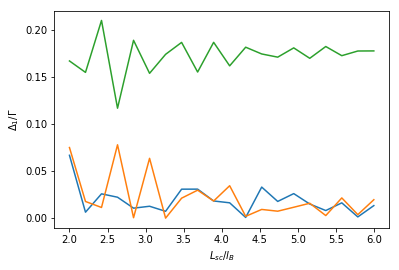

In [55]:
pyplot.figure()
# pyplot.plot(Ls_sw/lB,np.abs(np.imag(Hmat_off)/Hmat_diag))
pyplot.plot(Ls_sw/lB,np.abs(np.real(Hmat_off)))
pyplot.plot(Ls_sw/lB,np.abs(np.imag(Hmat_off)))
pyplot.plot(Ls_sw/lB,np.abs(Hmat_diag))
# pyplot.plot(Ls_sw/lB,np.abs(np.imag(Hmat_off)/np.real(Hmat_off)))
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$\Delta_1/\Gamma$")
pyplot.show()